In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import pandas as pd
import os
from PIL import Image, ImageOps
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import io
import zipfile

In [100]:
zip_path = "/content/drive/MyDrive/ImageCaption/images.zip"
output_zip_path = "/content/drive/MyDrive/ImageCaption/model_build.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    image_files = [f for f in zip_ref.namelist() if f.lower().endswith('.jpg')]

    selected_images = random.sample(image_files, min(5000, len(image_files)))

    with zipfile.ZipFile(output_zip_path, 'w') as new_zip:
        for img in selected_images:
            new_zip.writestr(img, zip_ref.read(img))

print(f"Saved filtered dataset with {len(selected_images)} images to: {output_zip_path}")

Saved filtered dataset with 5000 images to: /content/drive/MyDrive/ImageCaption/model_build.zip


In [101]:
data = pd.read_csv('/content/drive/MyDrive/ImageCaption/results.csv', sep='|')
data["image_name"] = "images/" + data["image_name"]
data["image_name"] = data["image_name"].str.strip()
data.columns = data.columns.str.strip()
data

,image_name,comment_number,comment
0,images/1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,images/1000092795.jpg,1,"Two young , White males are outside near many..."
2,images/1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,images/1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,images/1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,images/998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,images/998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,images/998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,images/998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [102]:
output_zip_path = "/content/drive/MyDrive/ImageCaption/model_build.zip"
with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    selected_image_names = set(zip_ref.namelist())

data = data[data['image_name'].isin(selected_image_names)]

print(f"Filtered {len(data)} captions for selected images.")

Filtered 25000 captions for selected images.


In [103]:
zip_size = os.path.getsize(output_zip_path) / (1024 * 1024)

with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    image_files = [f for f in zip_ref.namelist() if f.lower().endswith('.jpg')]
    num_images = len(image_files)

print(f"📂 ZIP File Size: {zip_size:.2f} MB")
print(f"🖼️ Number of Images: {num_images}")

📂 ZIP File Size: 658.96 MB
🖼️ Number of Images: 5000


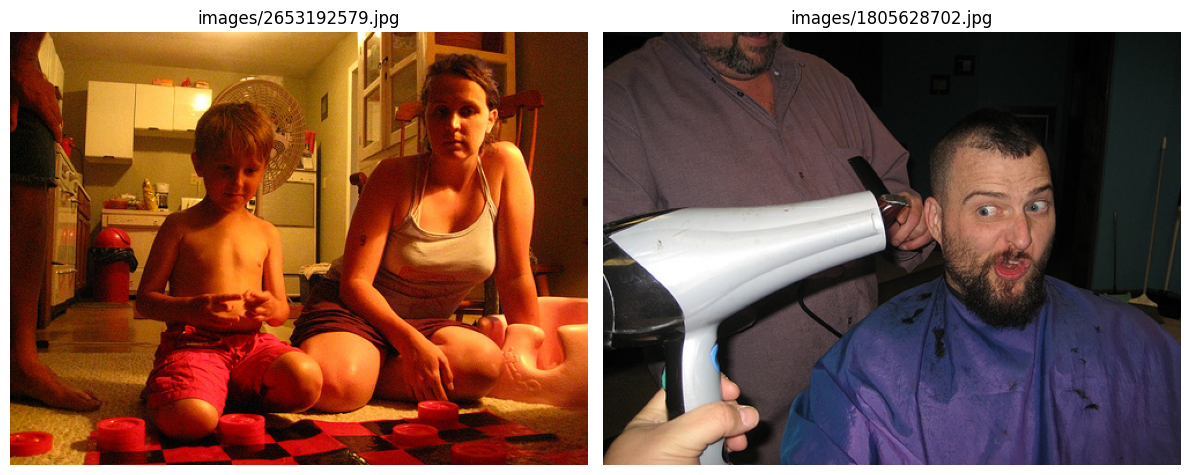

Plotted images: images/2653192579.jpg, images/1805628702.jpg


In [104]:
with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    image_files = [f for f in zip_ref.namelist() if f.lower().endswith('.jpg')]

    sample_images = random.sample(image_files, 2)

    image1 = Image.open(io.BytesIO(zip_ref.read(sample_images[0])))
    image2 = Image.open(io.BytesIO(zip_ref.read(sample_images[1])))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image1)
    axes[0].axis("off")
    axes[0].set_title(sample_images[0])

    axes[1].imshow(image2)
    axes[1].axis("off")
    axes[1].set_title(sample_images[1])

    plt.tight_layout()
    plt.show()

print(f"Plotted images: {sample_images[0]}, {sample_images[1]}")

In [105]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

r_mean, g_mean, b_mean = [], [], []
r_std, g_std, b_std = [], [], []

with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    image_files = [f for f in zip_ref.namelist() if f.lower().endswith('.jpg')]

    for image_name in tqdm(image_files, desc="Processing Images"):
        with zip_ref.open(image_name) as img_file:
            image = Image.open(io.BytesIO(img_file.read())).convert('RGB')
            image_tensor = transform(image)

            r_mean.append(image_tensor[0].mean().item())
            g_mean.append(image_tensor[1].mean().item())
            b_mean.append(image_tensor[2].mean().item())

            r_std.append(image_tensor[0].std().item())
            g_std.append(image_tensor[1].std().item())
            b_std.append(image_tensor[2].std().item())

mean = [np.mean(r_mean), np.mean(g_mean), np.mean(b_mean)]
std = [np.mean(r_std), np.mean(g_std), np.mean(b_std)]

print('Mean:', mean)
print('Std:', std)

Processing Images: 100%|██████████| 5000/5000 [00:33<00:00, 147.18it/s]

Mean: [np.float64(0.4423948547117412), np.float64(0.4215358098089695), np.float64(0.38510331883169713)]
Std: [np.float64(0.24141386586353183), np.float64(0.23116702369488776), np.float64(0.23263562424648554)]


In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [107]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4423948547117412, 0.4215358098089695, 0.38510331883169713],
                         std=[0.24141386586353183, 0.23116702369488776, 0.23263562424648554])
])

In [108]:
class ImageCaptionDataset(Dataset):
    def __init__(self, zip_path, data, transform=None, freq_threshold=5):
        self.zip_path = zip_path
        self.data = data
        self.transform = transform
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.data["comment"].tolist())

        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            self.image_files = {f for f in zip_ref.namelist() if f.lower().endswith('.jpg')}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]["image_name"]
        caption = self.data.iloc[idx]["comment"]

        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            with zip_ref.open(img_name) as img_file:
                img = Image.open(io.BytesIO(img_file.read())).convert("RGB")

        if self.transform:
            img = self.transform(img)

        caption_tokens = self.vocab.numericalize(caption)
        caption_tokens = [self.vocab.word2idx["<SOS>"]] + caption_tokens + [self.vocab.word2idx["<EOS>"]]

        return img, torch.tensor(caption_tokens)

In [109]:
import spacy
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {
            "<PAD>": 0,
            "<SOS>": 1,
            "<EOS>": 2,
            "<UNK>": 3
        }
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def __len__(self):
        return len(self.word2idx)

    def tokenizer(self, text):
        if not isinstance(text, str):
            text = ''
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentences):
        word_freq = Counter()

        for sentence in sentences:
            word_freq.update(self.tokenizer(sentence))

        for word, freq in word_freq.items():
            if freq >= self.freq_threshold:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.word2idx.get(word, self.word2idx["<UNK>"])
            for word in tokenized_text
        ]

In [110]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, captions = zip(*batch)

    captions_padded = pad_sequence(captions, batch_first=True, padding_value=0)

    return torch.stack(images), captions_padded

In [111]:
with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    zip_filenames = zip_ref.namelist()

print("Example filenames from ZIP:", zip_filenames[:10])


Example filenames from ZIP: ['images/2082399131.jpg', 'images/4520523965.jpg', 'images/4520820052.jpg', 'images/3256275785.jpg', 'images/3694528441.jpg', 'images/2282895743.jpg', 'images/29320312.jpg', 'images/2319539346.jpg', 'images/3932198441.jpg', 'images/363560757.jpg']


In [120]:
dataset = ImageCaptionDataset(output_zip_path, data, transform=image_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn, drop_last=True, pin_memory=True)

In [121]:
class AttentionCNNEncoder(nn.Module):
    def __init__(self, feature_dim=512, dropout=0.5):
        super(AttentionCNNEncoder, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.attention = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=1)
        )

        self.fc = nn.Linear(512, feature_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        features = self.conv_layers(x)  # Shape: (batch, 512, H, W)
        attention_weights = F.softmax(self.attention(features).squeeze(1), dim=-1).unsqueeze(1)  # Fix applied

        features = features * attention_weights  # Apply attention
        features = torch.sum(features, dim=[2, 3])  # Global weighted sum

        features = self.fc(features)
        features = F.normalize(features, p=2, dim=-1)
        return features  # Shape: (batch, feature_dim)

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, feature_dim=512, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.feature_proj = nn.Linear(feature_dim, hidden_dim)  # Convert image features to LSTM hidden state
        self.fc = nn.Linear(hidden_dim, vocab_size)  # Final prediction layer
        self.num_layers = num_layers

        # LSTM parameters for each layer
        self.W_i = nn.ModuleList([nn.Linear(embed_dim + hidden_dim, hidden_dim) for _ in range(num_layers)])  # Input Gate
        self.W_f = nn.ModuleList([nn.Linear(embed_dim + hidden_dim, hidden_dim) for _ in range(num_layers)])  # Forget Gate
        self.W_o = nn.ModuleList([nn.Linear(embed_dim + hidden_dim, hidden_dim) for _ in range(num_layers)])  # Output Gate
        self.W_c = nn.ModuleList([nn.Linear(embed_dim + hidden_dim, hidden_dim) for _ in range(num_layers)])  # Cell Update

    def lstm_cell(self, x, h_prev, c_prev, layer_idx):
        """ Custom LSTM cell implementation for a specific layer """
        combined = torch.cat((x, h_prev), dim=-1)  # (batch, embed_dim + hidden_dim)

        # Compute gates for this layer
        i = torch.sigmoid(self.W_i[layer_idx](combined))  # Input gate
        f = torch.sigmoid(self.W_f[layer_idx](combined))  # Forget gate
        o = torch.sigmoid(self.W_o[layer_idx](combined))  # Output gate
        c_tilde = torch.tanh(self.W_c[layer_idx](combined))  # Candidate cell state

        # Update cell state
        c_next = f * c_prev + i * c_tilde
        h_next = o * torch.tanh(c_next)  # Compute new hidden state

        return h_next, c_next

    def forward(self, captions, features):
        batch_size, seq_len = captions.shape
        captions = captions.long()

        # Embed captions
        embeddings = self.embed(captions)  # (batch, seq_len, embed_dim)

        # Initialize hidden and cell states for all layers
        h = [self.feature_proj(features)]  # First layer's initial hidden state
        c = [torch.zeros_like(h[0])]  # First layer's initial cell state

        # Create hidden/cell states for remaining layers
        for _ in range(1, self.num_layers):
            h.append(torch.zeros_like(h[0]))
            c.append(torch.zeros_like(c[0]))

        outputs = []

        # Process sequence one step at a time
        for t in range(seq_len):
            x_t = embeddings[:, t, :]  # Current word embedding

            for layer_idx in range(self.num_layers):
                h[layer_idx], c[layer_idx] = self.lstm_cell(x_t, h[layer_idx], c[layer_idx], layer_idx)
                x_t = h[layer_idx]  # Pass hidden state to next layer

            output_t = self.fc(h[-1])  # Predict next word from last layer's hidden state
            outputs.append(output_t)

        outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, vocab_size)
        return outputs


In [123]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder, vocab):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab = vocab

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(captions, features)
        return outputs

    def generate(self, images, max_length=20, num_beams=5, repetition_penalty=1.2, length_penalty=0.8):
        self.eval()
        with torch.no_grad():
            features = self.encoder(images)  # Extract image features
            batch_size = images.shape[0]
            captions = torch.zeros((batch_size, max_length), dtype=torch.long, device=images.device)
            captions[:, 0] = self.vocab.word2idx["<SOS>"]

            for t in range(1, max_length):
                predictions = self.decoder(captions[:, :t].long(), features)
                logits = predictions[:, -1, :]

                # Apply repetition penalty
                logits = logits / repetition_penalty

                # Beam Search: Keep top num_beams predictions
                top_logits, top_indices = torch.topk(logits, num_beams, dim=-1)
                probs = F.softmax(top_logits, dim=-1)

                # Sample the next word from the beam
                sampled_idx = top_indices[torch.arange(batch_size), torch.multinomial(probs, 1).squeeze()]

                captions[:, t] = sampled_idx

                # Stop early if all captions generated <EOS>
                if (sampled_idx == self.vocab.word2idx["<EOS>"]).all():
                    break

        return captions.cpu().tolist()

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

embed_dim = 256
hidden_dim = 512
num_epochs = 10
learning_rate = 0.0003
clip_grad = 5
encoder = AttentionCNNEncoder()
decoder = LSTMDecoder(embed_dim=256, hidden_dim=512, vocab_size=10000)
vocab = Vocabulary()

model = ImageCaptioningModel(encoder, decoder, vocab).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [125]:
for param in model.parameters():
    print(param.device)
    break  # No need to print all


cuda:0


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batchi, (images, captions) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        captions = captions.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = model(images, captions[:, :-1])
        targets = captions[:, 1:]

        outputs = outputs[:, :targets.shape[1], :]

        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = targets.contiguous().view(-1)

        loss = criterion(outputs, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

        optimizer.step()
        total_loss += loss.item()

        if (batchi + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batchi+1}/{len(train_loader)}] | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("Done")


Epoch [1/10] | Batch [10/312] | Loss: 8.8626
Epoch [1/10] | Batch [20/312] | Loss: 6.9239
Epoch [1/10] | Batch [30/312] | Loss: 5.1677
Epoch [1/10] | Batch [40/312] | Loss: 4.9399
Epoch [1/10] | Batch [50/312] | Loss: 4.6997
Epoch [1/10] | Batch [60/312] | Loss: 4.7246
Epoch [1/10] | Batch [70/312] | Loss: 4.7320
Epoch [1/10] | Batch [80/312] | Loss: 4.4463
Epoch [1/10] | Batch [90/312] | Loss: 4.4183
Epoch [1/10] | Batch [100/312] | Loss: 4.3390
Epoch [1/10] | Batch [110/312] | Loss: 4.1711
Epoch [1/10] | Batch [120/312] | Loss: 4.2721
Epoch [1/10] | Batch [130/312] | Loss: 4.2560
Epoch [1/10] | Batch [140/312] | Loss: 4.2180
Epoch [1/10] | Batch [150/312] | Loss: 4.2125
Epoch [1/10] | Batch [160/312] | Loss: 4.1423
Epoch [1/10] | Batch [170/312] | Loss: 4.1107
Epoch [1/10] | Batch [180/312] | Loss: 3.9831
Epoch [1/10] | Batch [190/312] | Loss: 3.9782
Epoch [1/10] | Batch [200/312] | Loss: 3.8984
Epoch [1/10] | Batch [210/312] | Loss: 3.8227
Epoch [1/10] | Batch [220/312] | Loss: 3.98

In [33]:
!git clone https://github.com/tylin/coco-caption.git
!pip install git+https://github.com/salaniz/pycocoevalcap
from pycocoevalcap.cider.cider import Cider


Cloning into 'coco-caption'...
remote: Enumerating objects: 736, done.
remote: Total 736 (delta 0), reused 0 (delta 0), pack-reused 736 (from 1)
Receiving objects: 100% (736/736), 130.04 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (390/390), done.
  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-osclsn5f
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-osclsn5f
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=6451945965ad73748c0b35b99234cf3cca8b761af252604c615355b794bf910c
  Stored in directory: /tmp/pip-ephem-wheel-cache-47jnmi1v/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


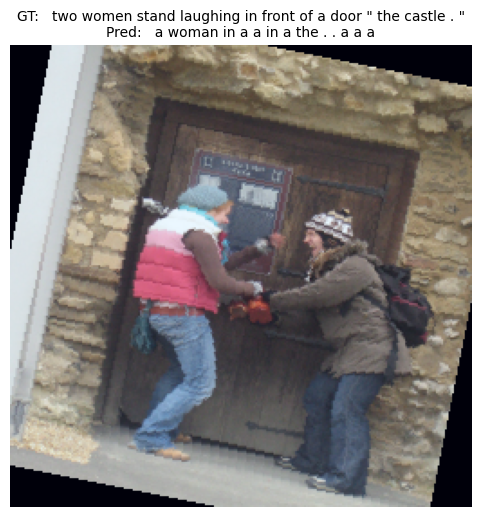

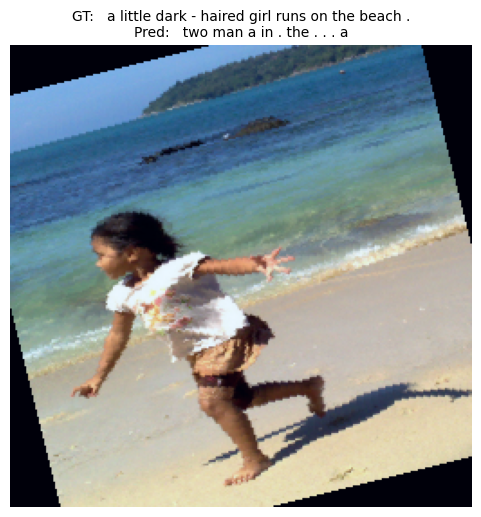

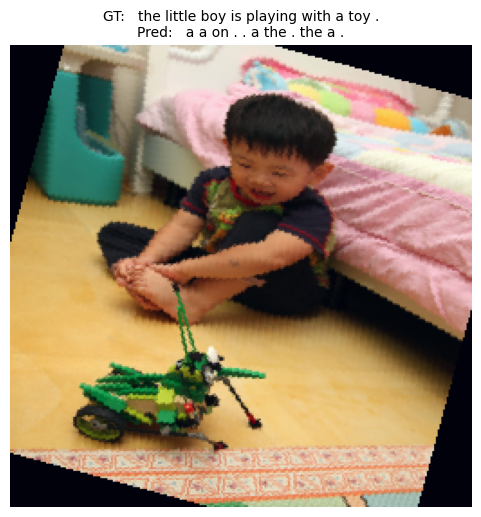


📊 Average CIDEr Score: 0.1202


In [98]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pycocoevalcap.cider.cider import Cider

def evaluate_model_cider(model, test_loader, vocab, device):
    model.eval()
    cider = Cider()
    all_scores = []

    with torch.no_grad():
        for batchi, (images, captions) in enumerate(test_loader):
            images = images.to(device)

            # Generate captions (Greedy decoding)
            predicted_captions = model.generate(images, max_length=20)

            # Convert predictions & ground truth to text
            predicted_texts = [
                " ".join([vocab.idx2word[idx] for idx in caption if idx not in {0, 1, 2, 3}])
                for caption in predicted_captions
            ]

            gt_texts = [
                [" ".join([vocab.idx2word[idx] for idx in caption if idx not in {0, 1, 2, 3}])]
                for caption in captions.tolist()
            ]

            # Compute CIDEr score
            references = {i: gt_texts[i] for i in range(len(gt_texts))}
            hypotheses = {i: [predicted_texts[i]] for i in range(len(predicted_texts))}
            score, _ = cider.compute_score(references, hypotheses)
            all_scores.append(score)

            # Plot images with captions (First few images only)
            if batchi < 3:
                plot_image_with_caption(images[0].cpu(), gt_texts[0][0], predicted_texts[0])

    avg_cider = sum(all_scores) / len(all_scores)
    print(f"\n📊 Average CIDEr Score: {avg_cider:.4f}")

def plot_image_with_caption(image_tensor, ground_truth, predicted):
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"GT: {ground_truth}\nPred: {predicted}", fontsize=10)
    plt.show()

# Run evaluation
evaluate_model_cider(model, test_loader, test_loader.dataset.dataset.vocab, device)

In [ ]:
for images, captions in test_loader:
    print(captions.dtype)  # Should print torch.int64 (LongTensor)


torch.int64
torch.int64
torch.int64
